In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix


plt.style.use('fivethirtyeight')

In [5]:
!pip install scikit-learn

                                              0.0/9.2 MB ? eta -:--:--
                                              0.0/9.2 MB ? eta -:--:--
                                              0.1/9.2 MB 653.6 kB/s eta 0:00:15
     -                                        0.3/9.2 MB 2.0 MB/s eta 0:00:05
     --                                       0.6/9.2 MB 3.1 MB/s eta 0:00:03
     ---                                      0.7/9.2 MB 3.2 MB/s eta 0:00:03
     ---                                      0.9/9.2 MB 3.2 MB/s eta 0:00:03
     ---                                      0.9/9.2 MB 3.2 MB/s eta 0:00:03
     ---                                      0.9/9.2 MB 3.2 MB/s eta 0:00:03
     ---                                      0.9/9.2 MB 3.2 MB/s eta 0:00:03
     ----                                     1.1/9.2 MB 2.4 MB/s eta 0:00:04
     -----                                    1.4/9.2 MB 2.6 MB/s eta 0:00:04
     ------                                   1.5/9.2 MB 2.7 MB/s eta 0:00:0

In [46]:
## Loading the data

ROOT_DIR = 'MNIST'

train_data = datasets.MNIST(
    root = ROOT_DIR,
    train = True,
    transform = transforms.ToTensor(),
    target_transform = None,
    download = True   

)

test_data = datasets.MNIST(
    root = ROOT_DIR,
    train = False,
    transform = transforms.ToTensor(),
    target_transform = None,
    download = True   

)

In [47]:
train_data.data.dtype

torch.uint8

In [48]:
train_data.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

<Axes: >

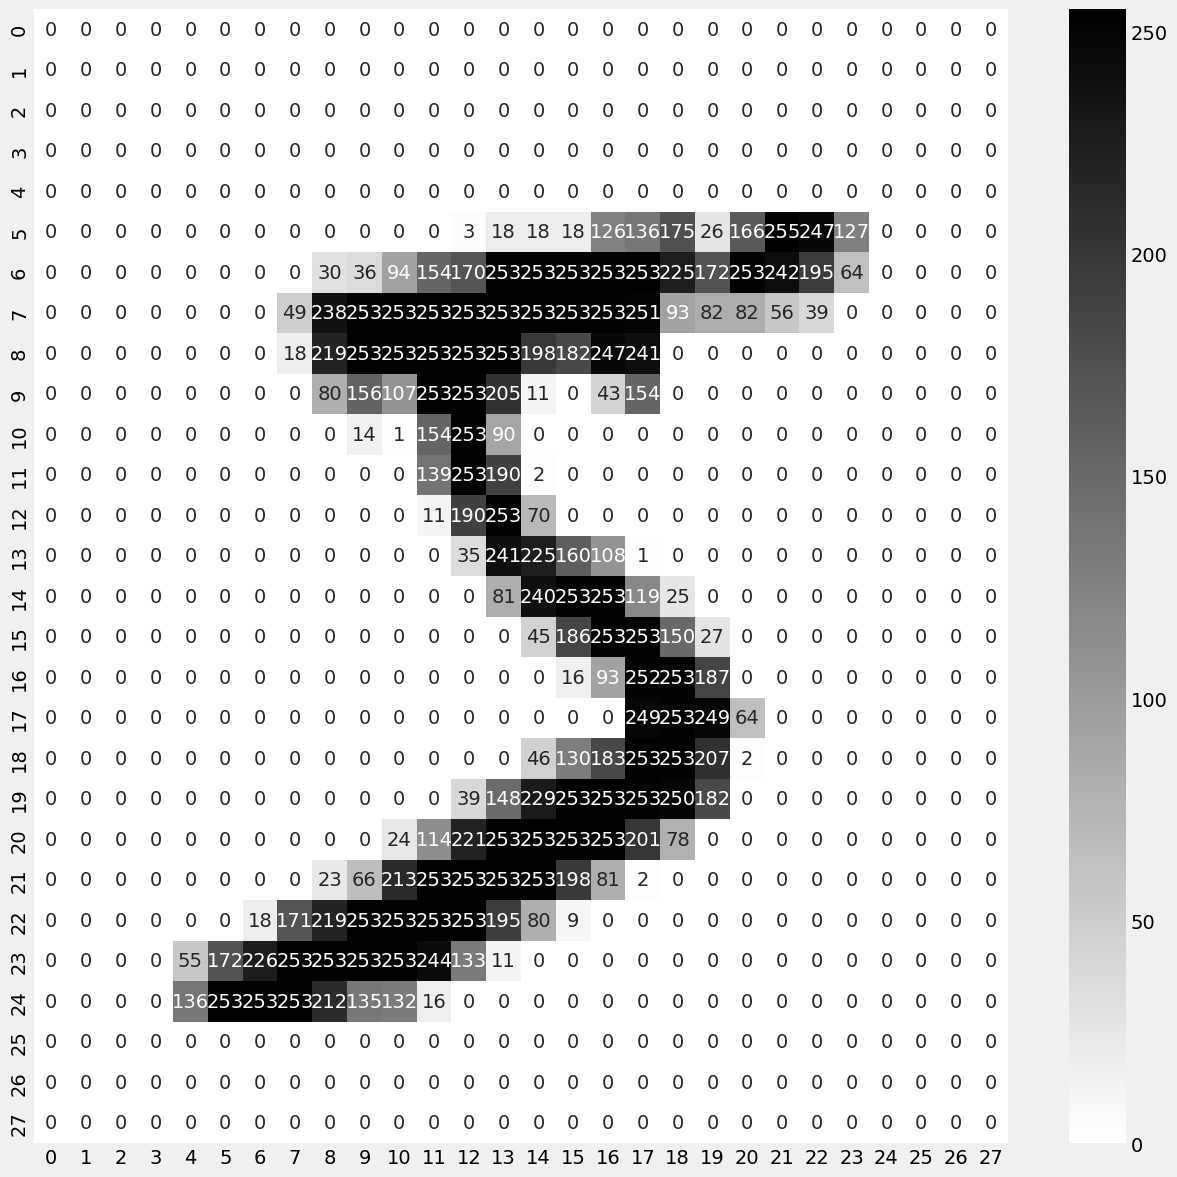

In [49]:
plt.figure(figsize=(14,14))
sns.heatmap(train_data.data[0], annot=True,cmap="binary", fmt='d')

In [11]:
train_data.data[0].shape

torch.Size([28, 28])

In [12]:
train_data.data[0].min().numpy(), train_data.data[0].max().numpy()

(array(0, dtype=uint8), array(255, dtype=uint8))

In [13]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [15]:
train_data.targets.dtype

torch.int64

In [16]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [17]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [50]:
BATCH=128

train_data_loader = DataLoader(dataset=train_data,
                              batch_size=BATCH,
                              shuffle=True)

test_data_loader = DataLoader(dataset=test_data,
                             batch_size=BATCH)

In [51]:
for x in test_data_loader:
    print(x[0].shape)
    print(x[1].shape)    
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [52]:
DEVICE = "cuda" if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [53]:
# Lets define the model

class NeuralNetwork(nn.Module):
    def __init__(self, in_, out_):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, out_)
        )
        
    def forward(self, x):
        return self.layers(x)

In [54]:
model = NeuralNetwork(784, 10)

model.to(DEVICE)

model

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [55]:
model.parameters()

<generator object Module.parameters at 0x000001126131E5E0>

In [56]:
CE_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [57]:
## Training loop
EPOCHS = 10
loss_ = list()
acc_ = list()


for epoch in range(EPOCHS):
    print(f"Epoch: {epoch + 1}/{EPOCHS}")
    for batch, data in enumerate(train_data_loader):
        x = data[0].to(DEVICE)
        y = data[1].to(DEVICE)
        
        optimizer.zero_grad()
        
        y_pred = model(x.reshape(-1, 784))
        
        loss = CE_loss(y_pred, y)
        
        loss_.append(loss.item())
        loss.backward()
        optimizer.step()
        
        accuracy = torch.mean((torch.argmax(y_pred, 1) == y).float()).item()
        acc_.append(accuracy)
        
        if batch%100 == 0:
            print(f"   Batch: {batch}, Loss: {loss.item():.4f} Accuracy {accuracy:.4f}")

Epoch: 1/10
   Batch: 0, Loss: 2.3155 Accuracy 0.0703
   Batch: 100, Loss: 0.3144 Accuracy 0.8828
   Batch: 200, Loss: 0.2850 Accuracy 0.9219
   Batch: 300, Loss: 0.2058 Accuracy 0.9453
   Batch: 400, Loss: 0.2182 Accuracy 0.9453
Epoch: 2/10
   Batch: 0, Loss: 0.2282 Accuracy 0.9688
   Batch: 100, Loss: 0.1446 Accuracy 0.9531
   Batch: 200, Loss: 0.1919 Accuracy 0.9688
   Batch: 300, Loss: 0.1571 Accuracy 0.9766
   Batch: 400, Loss: 0.1497 Accuracy 0.9531
Epoch: 3/10
   Batch: 0, Loss: 0.1361 Accuracy 0.9688
   Batch: 100, Loss: 0.0724 Accuracy 0.9688
   Batch: 200, Loss: 0.0865 Accuracy 0.9922
   Batch: 300, Loss: 0.0978 Accuracy 0.9609
   Batch: 400, Loss: 0.0464 Accuracy 0.9766
Epoch: 4/10
   Batch: 0, Loss: 0.0462 Accuracy 0.9922
   Batch: 100, Loss: 0.1049 Accuracy 0.9766
   Batch: 200, Loss: 0.0575 Accuracy 0.9922
   Batch: 300, Loss: 0.0731 Accuracy 0.9688
   Batch: 400, Loss: 0.0165 Accuracy 1.0000
Epoch: 5/10
   Batch: 0, Loss: 0.0659 Accuracy 0.9766
   Batch: 100, Loss: 0.027

<Axes: >

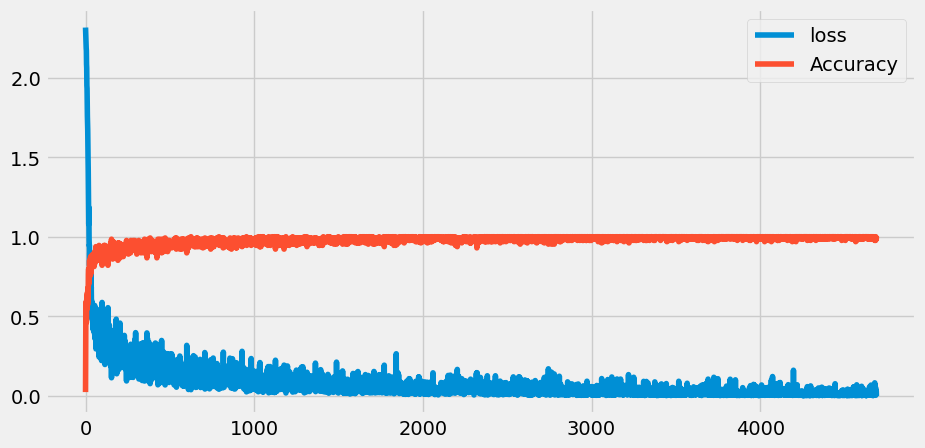

In [26]:
# plot the Train acc and loss
# plt.figure(figsize=(14,14))
pd.DataFrame(data={'loss': loss_, "Accuracy": acc_}).plot(figsize=(10,5))

In [27]:
# testing over the test data

test_loss = 0
test_acc = 0

with torch.no_grad():
    for batch, data in enumerate(test_data_loader):
        x = data[0].to(DEVICE)
        y = data[1].to(DEVICE)        
        
        y_pred = model(x.reshape(-1, 784))
        loss = CE_loss(y_pred, y)
        
        test_loss += loss.item()
        test_acc += torch.mean((torch.argmax(y_pred, 1) == y).float()).item()
        batch+=1

In [28]:
print(f"test loss: {test_loss/batch:.4f}, test accuracy: {test_acc/batch:.4f}")

test loss: 0.0855, test accuracy: 0.9778


In [29]:
pred = np.array([])
target = np.array([])

with torch.no_grad():
    for batch, data in enumerate(test_data_loader):
        x = data[0].to(DEVICE)
        y = data[1].to(DEVICE)        
        
        y_pred = model(x.reshape(-1, 784))
        loss = CE_loss(y_pred, y)
        
        pred = np.concatenate((pred, torch.argmax(y_pred, 1).cpu().numpy()))
        target = np.concatenate((target, y.cpu().numpy()))        

In [30]:
cm = confusion_matrix(target, pred)

<Axes: >

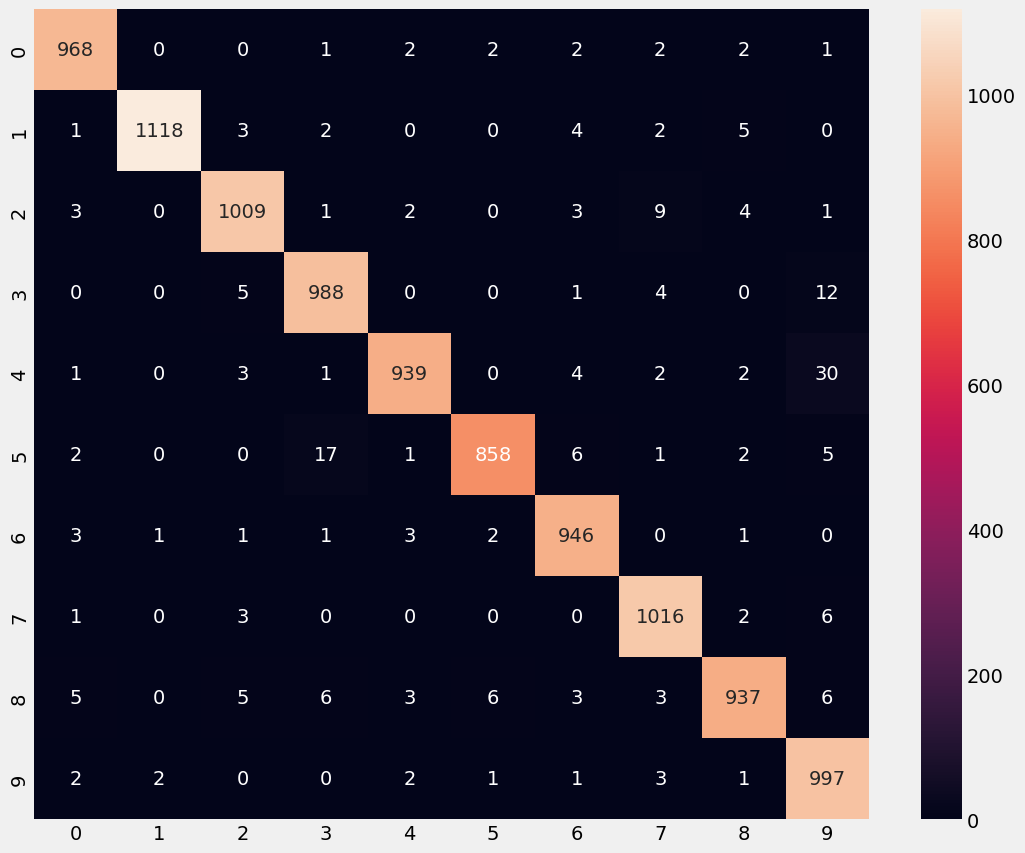

In [31]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d')

In [34]:
model = NeuralNetwork

# Save the entire model
torch.save(model, 'saved_model.pth')